An off-lattice particle-cluster polydisperse tunable sequential aggregation (PTSA) algorithm by Singh and Tsotas 2022, https://doi.org/10.1016/j.ces.2021.117022  

In [5]:
import numpy as np
import numba

In [6]:
@numba.njit
def ptsa(Np, mean_rp, rel_std_rp, Df, k, max_search_num, rng):
    """
    PTSA function

    Polydisperse tunable sequential aggregation (PTSA) method for generating fractal-like aggregate.
    Monomer radius follows a normal distribution with specified mean and standard deviation.
    The algorithms might fail depending on the combination of (k, Df).
    N.Moteki tested only k=0.95, and Df= 2.35~2.95, 

    ==== Input parameters ===
    Np: number of monomers
    mean_rp: mean of the normal distribution of the monomer radius
    rel_std_rp: relative standard deviation of the normal distrituion of the monomer radius 
    Df: fractal dimension
    k: fractal prefactor
    max_search_num: maximum number of iteration for searching a location of each monomer attached onto the surface of an aggregate (= 20000000)
    rng: random number generator constructed by the numpy.random.default_rng()

    === Output variables ===
    Np_final: number of monomers in the generated aggregate. If the aggregate generation failed, Np_final < Np.
    xp: (x,y,z) coordinate of the center of individual monomers relative to the centroid of the aggregate. 2D of shape= (Np,3).
    rp: radii of individual monomers. 1D array of size= Np.
    V: volume of the aggregate.
    Rve: volume-equivalent radius of the aggregate.
    Rg: gyration radius of aggregate.
    eps_agg: porosity of the aggregate calculated using the gyration method.

    reference: 
    Singh and Tsotas 2022, https://doi.org/10.1016/j.ces.2021.117022  

    Coded and tested by Nobuhiro Moteki, 2023-Jan-29th
    """

    #torelance of inter-monomer separation between attached monomers
    tol = 0.001+(2.95-Df)*0.0033 #tol= 0.001 @ Df=2.95, tol=0.003 @ Df=2.35

    # box muller method for genarating standard normal random vairable snv
    u1= rng.random(size= Np)
    u2= rng.random(size= Np)
    r= np.sqrt(-2.0*np.log(u1))
    theta= 2.0*np.pi*u2
    snv= r*np.cos(theta) # random number from the standard normal distribution

    # enforce outliers beyond 2 sigma to the boundary values
    for i, val in enumerate(snv):
        if val < -2:
            snv[i]= -2
        elif val > 2:
            snv[i]= 2

    rp= mean_rp*rel_std_rp*snv + mean_rp # radius of indivitual monomers (normal distribution) 
    density = 1.0 # monomer bulk density
    mp= (4*np.pi/3)*density*rp**3  # mass of individual monomers
    mp3t= np.broadcast_to(mp, (3,Np))
    mp3= mp3t.transpose() 
    xp= np.zeros((Np,3)) # 3D coordinates (x,y,z) of the centers of Np monomers
    minimum_separation= mean_rp*1e-6  # tolerance of intermonomer surface separation [um]

    xp[0,0],xp[0,1],xp[0,2]= 0.0,0.0,0.0
    # generate random point on a unit surface
    phi= rng.random()*2*np.pi
    u= rng.random()*2-1.0
    ux,uy,uz= np.sqrt(1-u**2)*np.cos(phi), np.sqrt(1-u**2)*np.sin(phi), u   # random position on the surface of the unit sphere
    R= rp[0]+rp[1]+minimum_separation # distance between the centers of 1st and 2nd monomers
    xp[1,0],xp[1,1],xp[1,2]= R*ux, R*uy, R*uz  # center position of 2nd monomer
    xp[0:2,:]= xp[0:2,:]- np.sum(mp3[0:2,:]*xp[0:2,:],axis=0)/np.sum(mp[0:2]) # shift the centroid to the origin 
    x= np.zeros(shape = (1,3))

    agg_generated= False
    Np_final=0
    for ip in range(2,Np):
        n= ip+1 # index of monomer (3,...,Np)
        Rpn= rp[ip] # radius of n-th monomer
        if n <= k**(3/(3-Df)):
            Df_tuned= 3
        else:
            Df_tuned= Df*(np.log(Np)/np.log(Np/k))  # Step 4. Compute tuned fractal dimension (at k=1) from the actual fractal dimensiton and prefactor (Df, k)
        R2= (n**2*Rpn**2/(n-1))*n**(2/Df_tuned)- (n*Rpn**2/(n-1))- n*Rpn**2*(n-1)**(2/Df_tuned)
        R= np.sqrt(R2)

        #maximum_separation= mean_rp*tol
        maximum_separation= mean_rp*tol*(1 + 5*(ip/Np)*(2.95-Df)/0.6)  # Np and Df dependent tuning for accerelation

        attached_cond= False
        for i_search in range(max_search_num):

            phi= rng.random()*2*np.pi
            u= rng.random()*2-1.0
            x[0,0], x[0,1], x[0,2]= R*np.sqrt(1-u**2)*np.cos(phi), R*np.sqrt(1-u**2)*np.sin(phi), R*u # a candidate of the center location of n-th monomer
            intermonomer_center_dist_from_x= np.sqrt((xp[0:ip,0]-x[0,0])**2+(xp[0:ip,1]-x[0,1])**2+(xp[0:ip,2]-x[0,2])**2)
            intermonomer_surface_dist= intermonomer_center_dist_from_x-(rp[0:ip]+rp[ip])

            non_overlapping_cond= np.all(intermonomer_surface_dist >= minimum_separation)
            if not non_overlapping_cond:
                continue

            proximity_cond= np.any(intermonomer_surface_dist < maximum_separation)
            if proximity_cond:
                attached_cond= True
                xp[ip,:]=x[0,:]
                xp[0:n,:]= xp[0:n,:]- np.sum(mp3[0:n,:]*xp[0:n,:],axis=0)/np.sum(mp[0:n]) # shift the centroid to the origin
                break

        Np_final=n
        if not attached_cond:
            break 
         
    if Np_final == Np:
        Rg= np.sqrt((1/np.sum(mp[:]))*np.sum(mp3[:,0]*((xp[:,0]**2+ xp[:,1]**2+ xp[:,2]**2) +3/5*rp[:]**2))) # Gyration radius
        Re= np.sqrt(5/3)*Rg # effectuve radius
        Vagg= 4*np.pi/3*Re**3 # effective volume
        V= np.sum(mp[:])/density # true volume
        Rve= np.cbrt(3*V/(4*np.pi)) # volume equivalent radius
        eps_agg= 1- V/Vagg # porosity
    else:
        Rg= 0
        Re= 0
        Vagg= 0
        V= 0
        Rve= 0
        eps_agg= 0
    
    return Np_final, xp, rp, V, Rve, Rg, eps_agg

In [7]:
### pre-execution of the ptsa for njit compilation ### 

mean_rp = 0.02 # mean monomer radius [um]  (user input)
rel_std_rp = 0.1 # relative standard deviation of monomer radius [-]  (user input)
Df =2.9 # fractal dimension (Df< 2.95)
k =0.9 # fractal prefactor (k<= 0.95)
tol = 0.003 # tolerance of intermonomer surface separation relative to the mean monomer radius
max_search_num= 2000000

Np=20
rng = np.random.default_rng()
Np_final, xp, rp, V, Rve, Rg, eps_agg = ptsa(Np, mean_rp, rel_std_rp, Df, k, max_search_num, rng)


agg_k=0.900_Df=2.90_meanRp=0.020um_rstdRp=0.10_Np=02000_Rve=0.254um_Rg=0.293um_epsagg=0.697.ptsa generated!


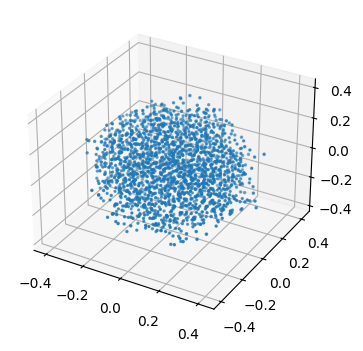

In [8]:
### execution of the njitted ptsa ### 

mean_rp = 0.02 # mean monomer radius [um]  (user input)
rel_std_rp = 0.1 # relative standard deviation of monomer radius [-]  (user input)
Np=2000 # number of monomers
Df =2.9 # fractal dimension (Df< 2.95)
k =0.9 # fractal prefactor (k<= 0.95)

max_search_num= 100000000

rng = np.random.default_rng()

Np_final, xp, rp, V, Rve, Rg, eps_agg = ptsa(Np, mean_rp, rel_std_rp, Df, k, max_search_num, rng)
                
if not Np_final == Np:
    # aggregate generation failed
    ofname= "agg_k={:5.3f}_Df={:4.2f}_meanRp={:5.3f}um_rstdRp={:4.2f}_Np={:05d}_Rve={:5.3f}um_Rg={:5.3f}um_epsagg={:5.3f}.ptsa".format(k, Df, mean_rp, rel_std_rp, Np, Rve, Rg, eps_agg)
    print(ofname+" failed!")
    with open("./generated_agg_files/" + ofname, 'w') as f:
        f.write("agg generation failed")
else:
    # aggregate generation succeeded
    ofname= "agg_k={:5.3f}_Df={:4.2f}_meanRp={:5.3f}um_rstdRp={:4.2f}_Np={:05d}_Rve={:5.3f}um_Rg={:5.3f}um_epsagg={:5.3f}.ptsa".format(k, Df, mean_rp, rel_std_rp, Np, Rve, Rg, eps_agg)
    print(ofname+" generated!", flush= True)
    
    # write the (x,y,z,rp) to file
    with open("./generated_agg_files/" + ofname, 'w') as f:
        for ip in range(Np):
            line= "{:13.7e}  {:13.7e}  {:13.7e}  {:13.7e}".format(xp[ip,0],xp[ip,1],xp[ip,2],rp[ip])
            f.write(line + '\n')

    # display
    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    s = rp
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xp[:,0], xp[:,1], xp[:,2], s=s * 100)
    plt.show()